**2021 빅데이터 통신 플랫폼 경진대회**

# 주제 : 코로나 시대, 배달의 왕국! 하지만 현실은 플라스틱 왕국?

## 부주제: 배달 데이터와 플라스틱 발생량 데이터를 통한 인사이트 도출

> 팀명: 홍길동 배달

> 팀원: 배달전문홍길동, 방역전문 홍길동, 홍길동홍보팀

# 목차
1. 개요
    - 목적
    - 활용 데이터(출처)
    - 적용 기술

2. 배달 데이터와 코로나 바이러스 간 관계
    - 배달 데이터 분석
    - 코로나 데이터 분석
    - 상관 관계 분석

3. 배달 데이터와 플라스틱 사용량 간 관계
    - 재활용 폐기물 발생량 분석
    - 상관 관계

4. 제안 및 기대효과
    - 필요성
    - 제안 및 기대효과

5. 참고 자료

### # 1. 개요

### 1-1. 목적



*   코로나 바이러스의 확산으로 인해 재택근무, 비대면 모임 등이 활성화 되었고, 자연스럽게 배달 이용량 역시 증가하고 있습니다. 

*   배달량이 증가함에 따라 이때 사용되는 플라스틱 폐기물 역시 증가하고 있습니다.
 
*   저희는 제공받은 코로나 바이러스 데이터, 배달량 데이터에 플라스틱 폐기물 데이터를 함께 분석하여 상관관계를 보이고, 이를 해결하기 위한 새로운 서비스를 제안하고자 합니다.



### 1-2. 활용 데이터(출처)

> **배달데이터(dlvr_call.csv)**
>> 음식점에서 배달을 위해 배달기사를 호출하고 고객에게 배달이 완료되는 과정에서 생산되는 데이터<br>
>> 출처 : KT 통신 빅데이터 플랫폼 내 경기대학교 데이터

<br>

> **코로나데이터(PatientInfo.csv)**
>> 2020년 코로나 확진자가 발생하는 과정에서 생산된 데이터<br>
>> 출처 : https://www.bigdata-telecom.kr

<br>

> **생활 폐기물 및 재활용품 데이터(생활,재활용폐기물_통합.xlsx)**
>> 2020년 서울시 각 구청에서 발생한 생활폐기물 및 재활용 폐기물이 발생하는 과정에서 생산된 데이터<br>
>> 출처 : https://www.data.go.kr/

### 1-3. 적용 기술

#### 사용한 라이브러리

In [4]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.pyplot import *

warnings.filterwarnings('ignore')

mpl.rc('font', family='Malgun Gothic')
plt.rc('font', family='Malgun Gothic')
matplotlib.style.use('fivethirtyeight')

from notebook.services.config import ConfigManager

cm = ConfigManager().update('notebook', {'limit_output': 1000000})
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [5]:
def hide_x_label(ax) : # x label을 숨기는 함수
    x_axis = ax.axes.get_xaxis()
    x_label = x_axis.get_label()
    x_label.set_visible(False)
    
def show_height(ax, height_unit, multiply, decimals, font_size = 12) : # bar 그래프의 높이를 표시하는 함수
    for a in ax.patches:
        txt = np.round(a.get_height() * multiply, decimals=decimals) 

        anot = txt.astype('str')
        ax.annotate(anot + height_unit, (a.get_x() +a.get_width()/2, a.get_height() ),
                    ha='center', va='center', xytext=(0, 10),
                    textcoords='offset points', fontsize=font_size)

<br>


# 2. 배달 데이터와 코로나 바이러스 간 관계

한국의 코로나 발생 이후의 관계를 분석하기 위해서 배달 데이터와 코로나 바이러스는 신천지 교회 확진자 발생 이후부터 배달 데이터의 마지막 날짜를 대상으로 분석하였습니다. 또한 저희는 플라스틱 

### 2-1. 배달 데이터 분석

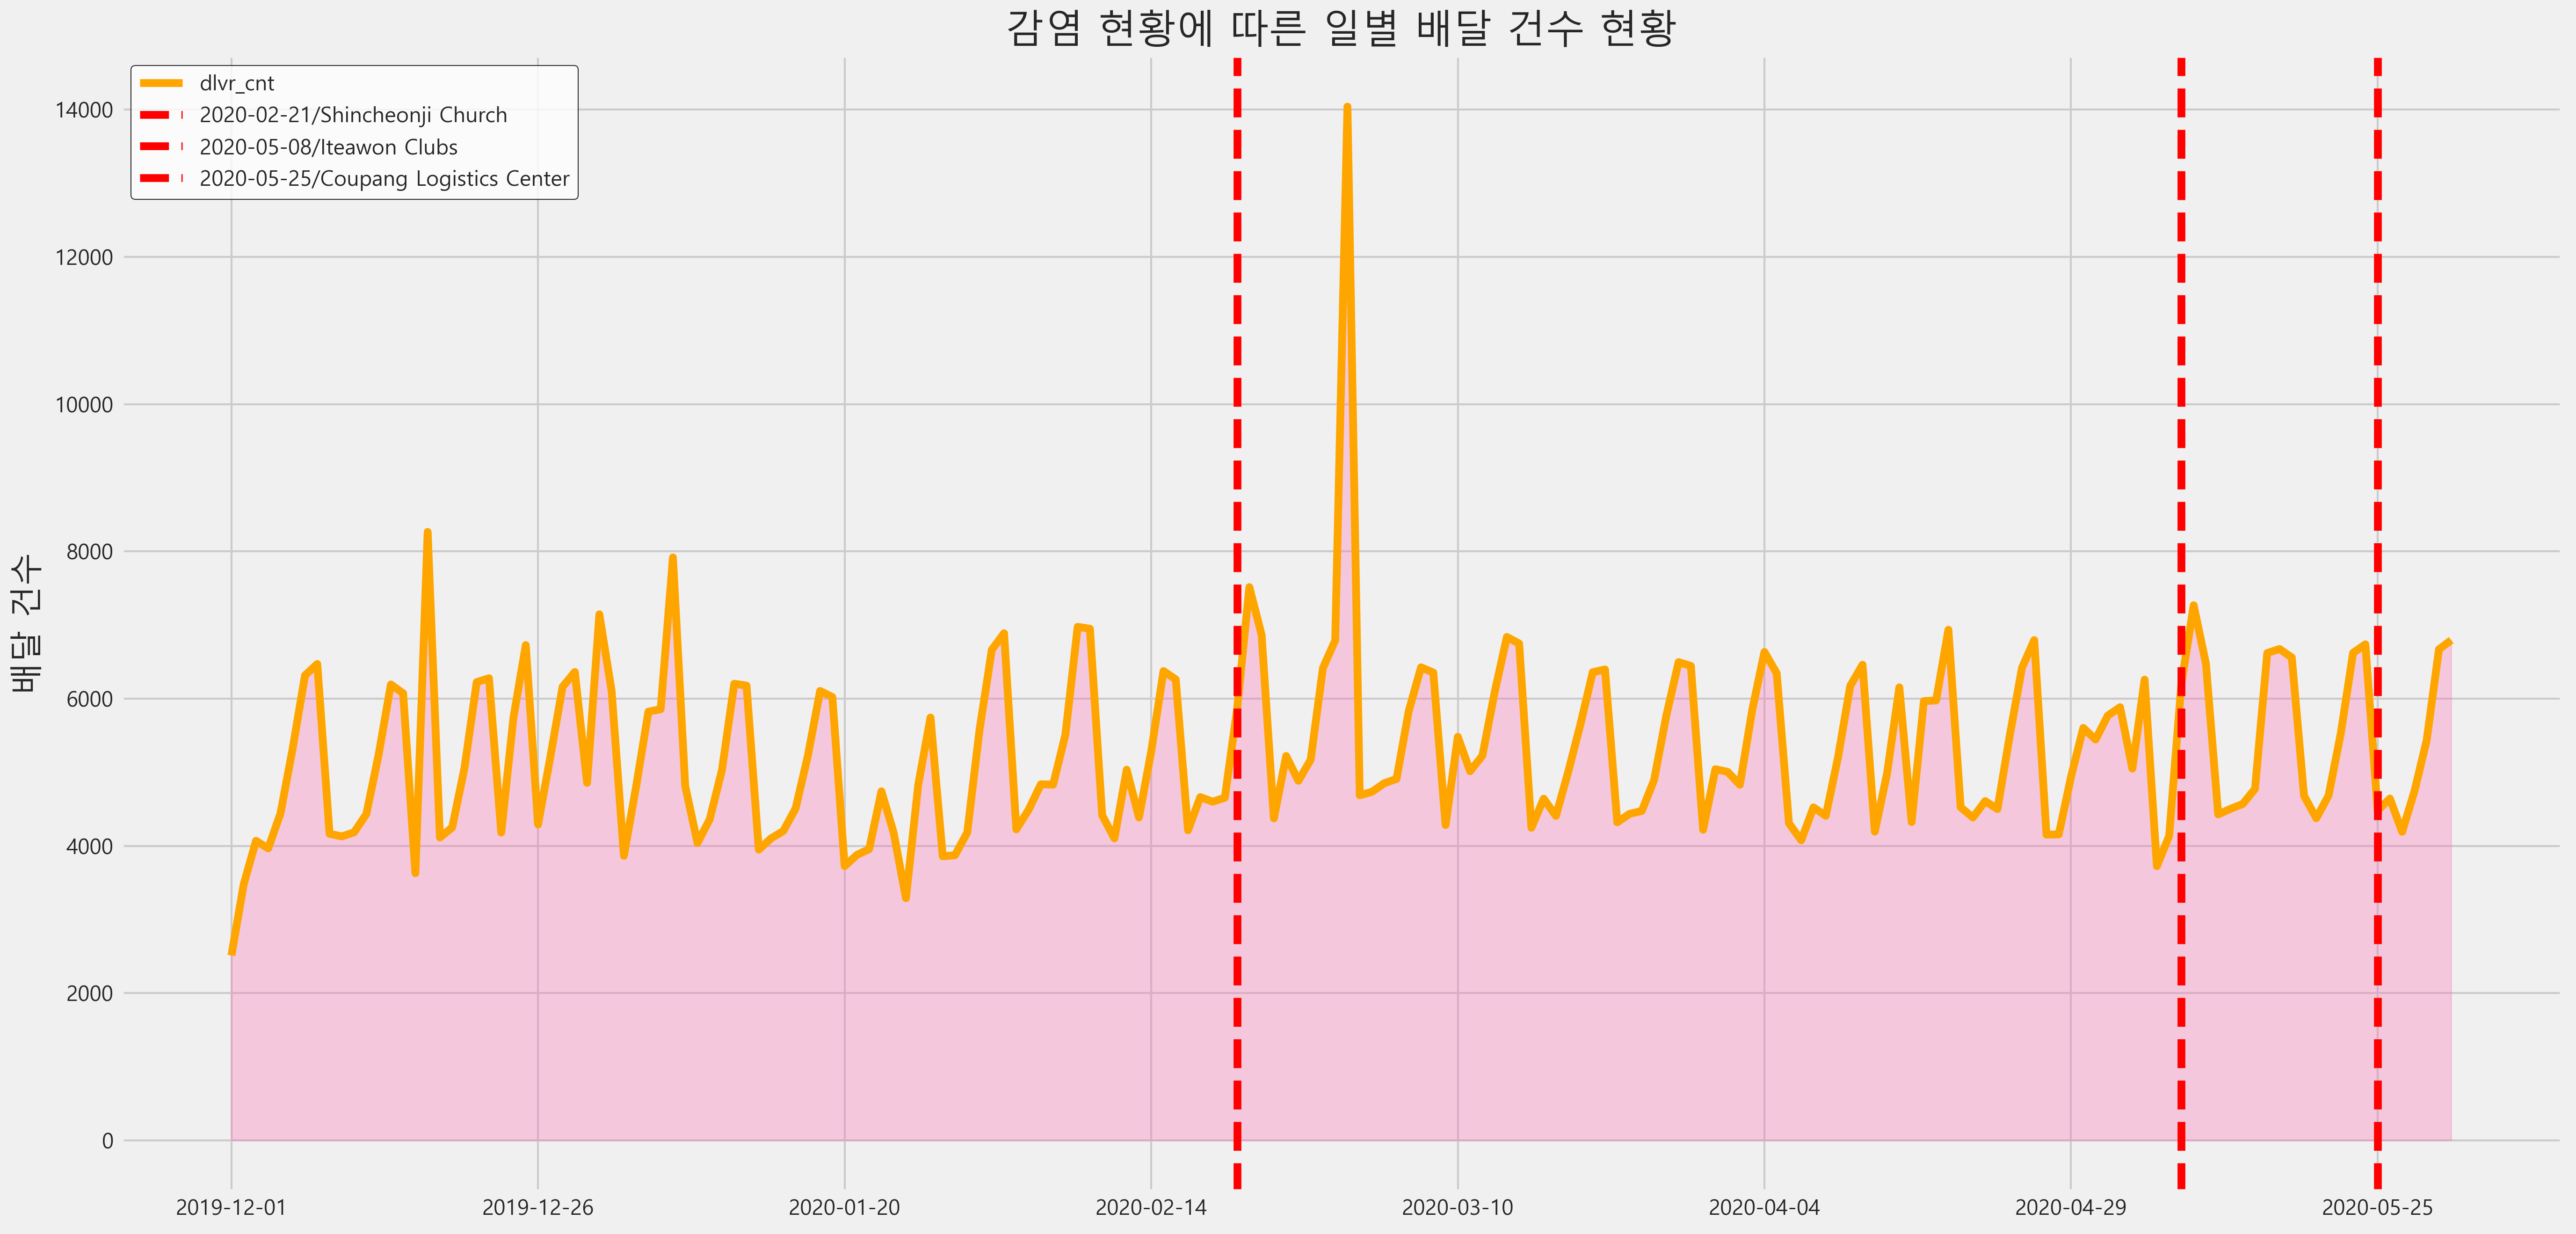

In [6]:
# 분석 시작일, 종료일
first_epidemic = "2020-02-21" # 한국 첫 유행 시작 날짜
end_date = "2020-05-31" # 마지막 배달 데이터의 날짜

# 배달 Data Read
dlvr_call = pd.DataFrame(pd.read_csv("KT_BigDataPlatform_dataset/dlvr_call.csv", encoding = "utf8"))

# 서울특별시의 배달 건만 Select
dlvr_call=dlvr_call[dlvr_call['DLVR_STORE_BRTC_NM'] == '서울특별시']

# 배달 완료된 주문만 사용
is_completed = dlvr_call["DLVR_REQUST_STTUS_VALUE"] == 1
dlvr_call = dlvr_call[is_completed]

# 서울의 배달 건수 현황
dlvr_call_cnt = dlvr_call.groupby('PROCESS_DT')['DLVR_REQUST_STTUS_VALUE'].count().reset_index(name='dlvr_cnt')

ax = dlvr_call_cnt.plot(x = "PROCESS_DT", y = ["dlvr_cnt"], figsize=(20,10), 
                        title = "감염 현황에 따른 일별 배달 건수 현황", ylabel = "배달 건수", color = "orange")

plt.fill_between(dlvr_call_cnt["PROCESS_DT"], dlvr_call_cnt["dlvr_cnt"], color = 'hotpink', alpha = .3)

#Patientinfo.csv의 infection_case를 반영
plt.axvline(x = '2020-02-21', color = 'red', linestyle = '--', label = '2020-02-21/Shincheonji Church')
plt.axvline(x = '2020-05-08', color = 'red', linestyle = '--', label = '2020-05-08/Iteawon Clubs')
plt.axvline(x = '2020-05-25', color = 'red', linestyle = '--', label = '2020-05-25/Coupang Logistics Center')

plt.legend(facecolor = "white", edgecolor= "black")
hide_x_label(ax)
plt.show()

In [7]:
# 전체 평균 배달 건수
total_avg_count=dlvr_call.groupby(["PROCESS_DT"])[['DLVR_REQUST_STTUS_VALUE']].count()    
total_avg_count=total_avg_count.mean()
print("전체 평균 배달 건수 : ",total_avg_count.values)

전체 평균 배달 건수 :  [5302.14285714]


>코로나 확진자 수와 서울 시 배달 건수의 상관관계를 알아보기 전 서울시의 2020년도 상반기 배달 건수에 대한 현황을 표현해 보았습니다.

>배달건수가 높아질 때를 확인해본 결과 코로나가 초기에 가장 많이 발생했던 신천지 교회 코로나 확진자 발생 이후에 배달이 높아진 것을 볼 수 있었고, 이태원 클럽, 쿠팡 물류센터 확진자 발생 이후 배달량이 증가하는 것을 확인할 수 있었습니다.

>배달건수와 코로나 확진자 수의 상관관계를 파악하기 위하여 2020년 2월 21일부터 2020년 5월 31일까지의 데이터를 추출하였습니다.

Text(0.5, 1.0, '코로나 전/후 업종별 배달 건수 비교')

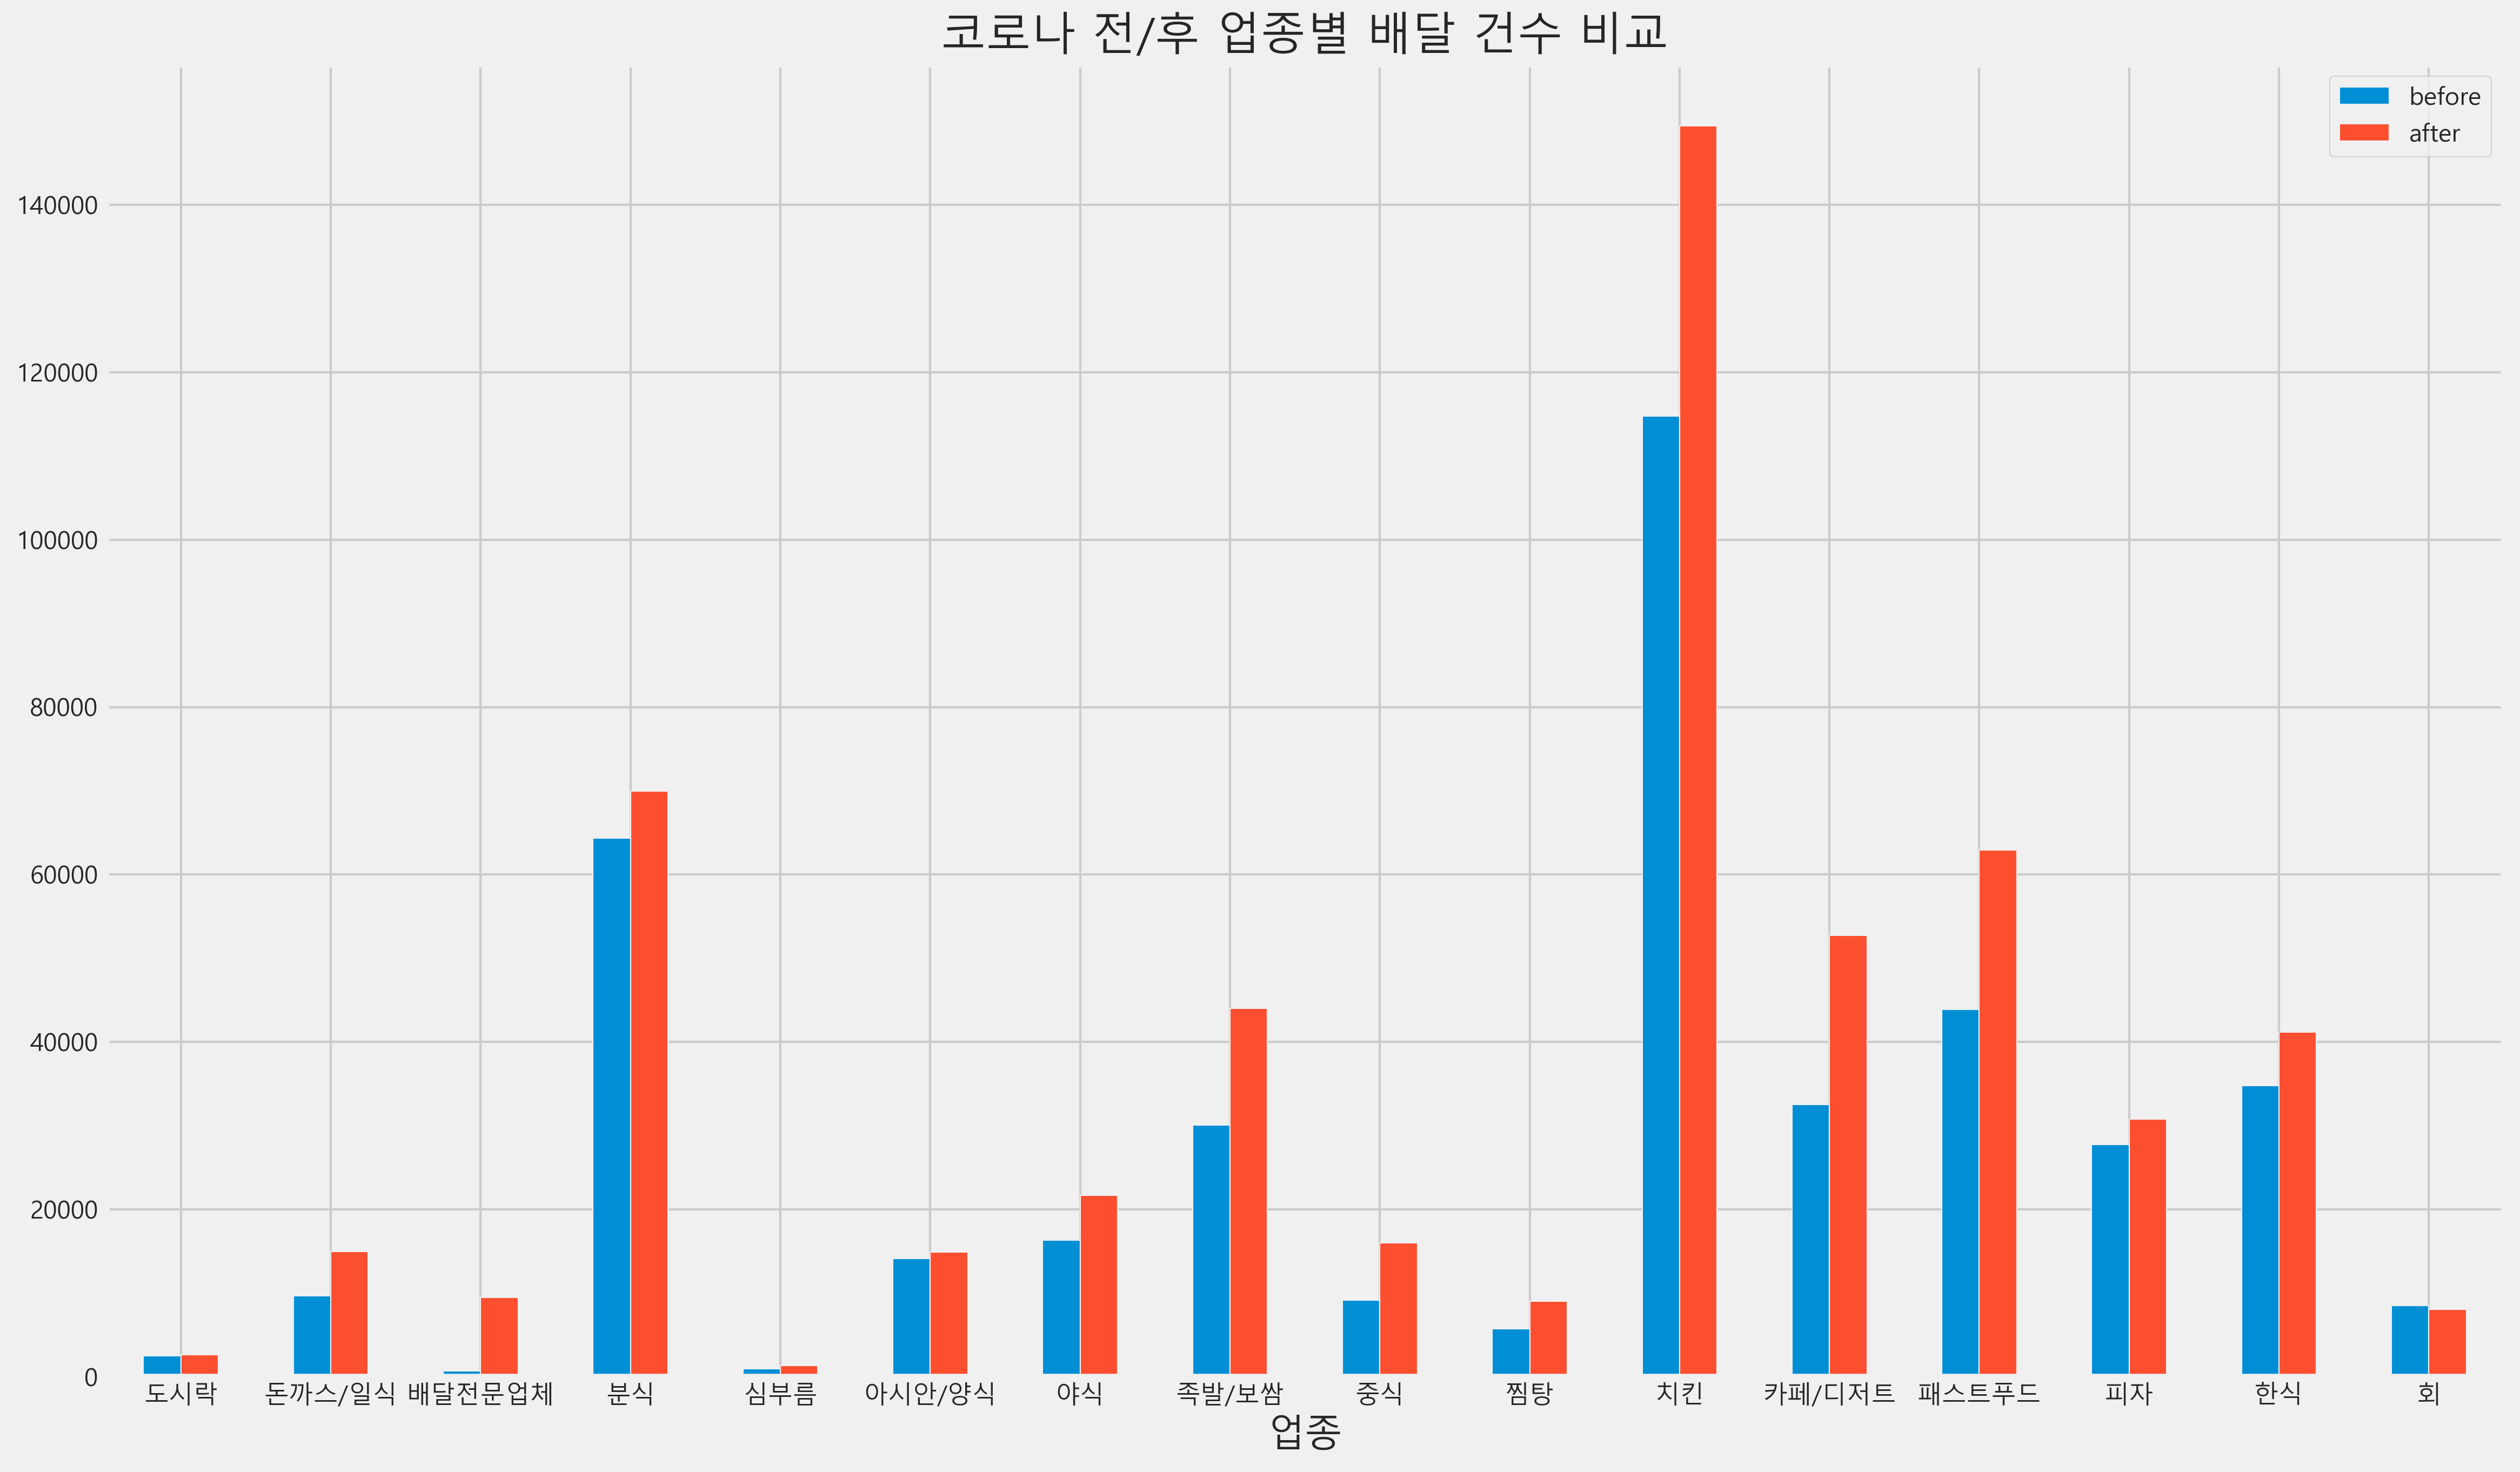

In [8]:

#업종 별 배달 건수 현황
dlvr_call['PROCESS_DT'] = pd.to_datetime(dlvr_call['PROCESS_DT'])
#코로나 전/후
before = dlvr_call[dlvr_call['PROCESS_DT'] < pd.to_datetime(first_epidemic)]
after = dlvr_call[dlvr_call['PROCESS_DT'] >= pd.to_datetime(first_epidemic)]

#코로나 전 후 업종별 배달 건수
before_induty_count=pd.DataFrame(before.groupby(['DLVR_STORE_INDUTY_NM'])['GOODS_AMOUNT'].count()).reset_index()
after_induty_count=pd.DataFrame(after.groupby(['DLVR_STORE_INDUTY_NM'])['GOODS_AMOUNT'].count()).reset_index()
before_induty_count.columns=['업종','before']
after_induty_count.columns=['업종','after']

total=before_induty_count.join(after_induty_count.set_index('업종'), on= '업종')
#시각화
total.plot(kind='bar',x='업종',rot=0,figsize=(17,10))
plt.title("코로나 전/후 업종별 배달 건수 비교",fontsize=20)


In [9]:
total

,업종,before,after
0,도시락,2511,2661
1,돈까스/일식,9661,14984
2,배달전문업체,687,9453
3,분식,64352,69982
4,심부름,943,1346
5,아시안/양식,14123,14906
6,야식,16313,21682
7,족발/보쌈,30088,44016
8,중식,9182,16008
9,찜탕,5704,9052


>코로나 발생 전과 후를 비교하여 업종별 배달 건수를 비교하였습니다. 
2019년과 2020년을 비교하려고 하였지만 2019년 데이터가 12월 데이터만 있어 2019년과 2020년을 비교하기에 데이터의 양이 너무 적었기에2020년 2월 21일 기준인 신천지교회 확진자 발생일을 기준으로 비교를 하였습니다.

>코로나 전과 후를 비교하였을 때, 급격하게 증가한 것으로 보이는 분야는 카페/디저트류, 족발/보쌈, 돈까스/일식, 그리고 배달전문업체가 있었습니다. 

>* <b>배달전문업체는 코로나 발생 이후 약 13배의 배달 증가량을 보여주는 것으로 확인 되었습니다.</b>

>배달전문업체의 배달량 증가로 인하여 배달전문업체의 창업량도 같이 증가하였는지 분석해보았습니다.

### 2-2. 코로나 데이터 분석

In [11]:
# 코로나 환자 Data Read, 서울 지역만 select
corona = pd.read_csv('./covid_19_dataset/PatientInfo.csv')
is_seoul= corona["province"] == "Seoul"
corona = corona[is_seoul]


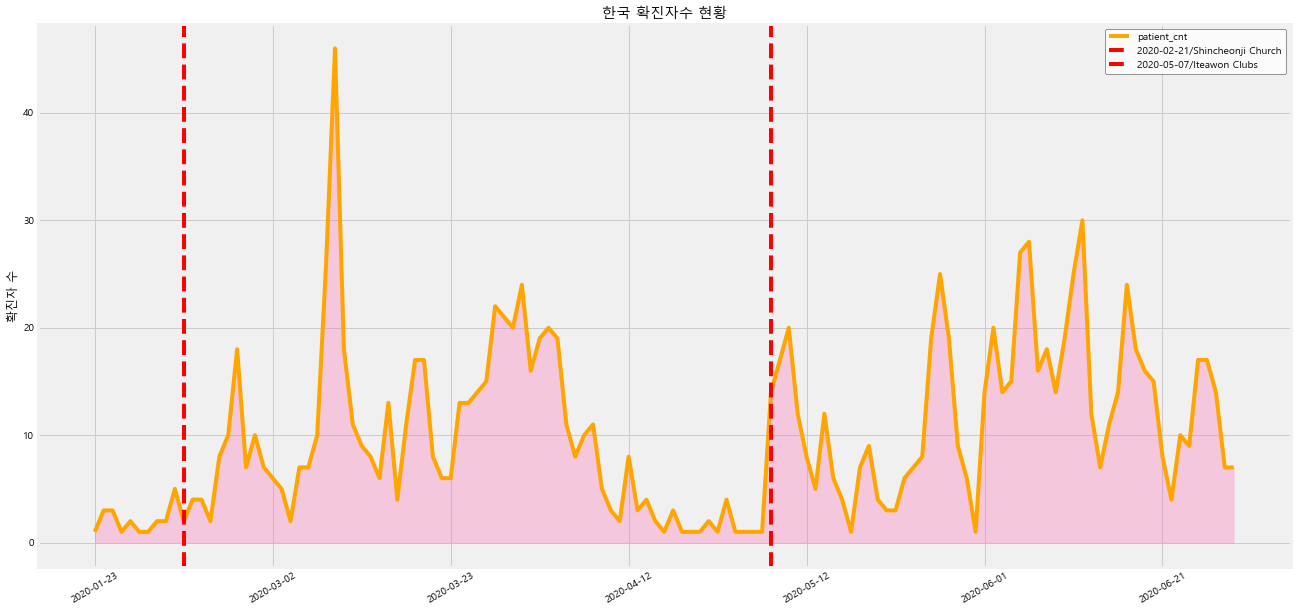

In [ ]:
# 서울 지역의 코로나 일일 확진자 수 추이 시각화
confirmed_cnt = corona.groupby('confirmed_date')["patient_id"].count().reset_index(name='patient_cnt')

ax = confirmed_cnt.plot(x = "confirmed_date", y = ["patient_cnt"], figsize = (20,10), 
                        rot = 30, title = "한국 확진자수 현황", color = "orange", ylabel = "확진자 수")

plt.fill_between(confirmed_cnt["confirmed_date"], confirmed_cnt["patient_cnt"], color = 'hotpink', alpha = .3)

plt.axvline(x = '2020-02-21', color = 'red', linestyle = '--', label = '2020-02-21/Shincheonji Church')
plt.axvline(x = '2020-05-08', color = 'red', linestyle = '--', label = '2020-05-07/Iteawon Clubs')

hide_x_label(ax)
plt.legend(facecolor = "white", edgecolor= "black")
plt.show()

>2020년 코로나 확진자가 처음 발생하면서 신천지교회에서 코로나 확진자가 발생했을 때와 이태원 클럽에서 코로나 확진자가 발생했을 때를 시점으로 급격하게 증가함을 알 수 있었습니다.

### 2-3. 상관 관계 입증

(0.7803705269278044, 0.2196294730721956)

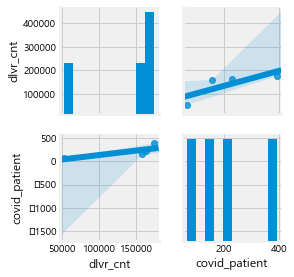

In [ ]:
# 분석 시작일과 종료일 사이의 배달 건수, 확진자 정보 select
dlvr_call = dlvr_call[dlvr_call["PROCESS_DT"] >= first_epidemic]
dlvr_call = dlvr_call[dlvr_call["PROCESS_DT"] <= end_date]
corona = corona[corona["confirmed_date"] >= first_epidemic]
corona = corona[corona["confirmed_date"] <= end_date]



dlvr_call_cnt = pd.DataFrame(dlvr_call.groupby('PROCESS_DT')[['GOODS_AMOUNT']].count().to_records())
dlvr_call_cnt['PROCESS_DT']=pd.to_datetime(dlvr_call_cnt['PROCESS_DT'])
dlvr_call_cnt['month_year'] = dlvr_call_cnt['PROCESS_DT'].dt.to_period('M')

dlvr_call_1M_cnt = pd.DataFrame(dlvr_call_cnt.groupby('month_year')[['GOODS_AMOUNT']].sum().to_records())

corona_cnt = pd.DataFrame(corona.groupby('confirmed_date')[['country']].count().to_records())

corona_cnt['confirmed_date']=pd.to_datetime(corona_cnt['confirmed_date'])
corona_cnt['month_year'] = corona_cnt['confirmed_date'].dt.to_period('M')

corona_1M_cnt = pd.DataFrame(corona_cnt.groupby('month_year')[['country']].sum().to_records())

#상관관계분석
correlation=dlvr_call_1M_cnt.join(corona_1M_cnt.set_index('month_year'), on= 'month_year')
correlation.columns=['Date','dlvr_cnt','covid_patient']

#그래프 시각화
sns.pairplot(correlation, kind='reg', height=2) 


# 피어슨 상관계수 검정
corr = stats.pearsonr(correlation.dlvr_cnt, correlation.covid_patient)
corr

>2020년 상반기 코로나 확진자 수와 배달량을 상관분석해보았습니다.

>확진자 수가 늘어남으로써 배달량도 증가하는 것은 상관계수가 0.78로 상관관계가 높게 나왔으며 배달량 데이터와 코로나 데이터 사이의 연관성을 보여주고 있습니다. 



# 3. 배달 데이터와 플라스틱 사용량 간 관계 입증

### 3-1. 플라스틱 사용량 분석

In [ ]:
# 재활용폐기물 Data Read
Recycle_waste = pd.read_excel("external data/생활,재활용폐기물_통합.xlsx", sheet_name = "재활용폐기물")

In [ ]:
Recycle_waste = Recycle_waste[Recycle_waste["년-월"] < "2021-07-01"]

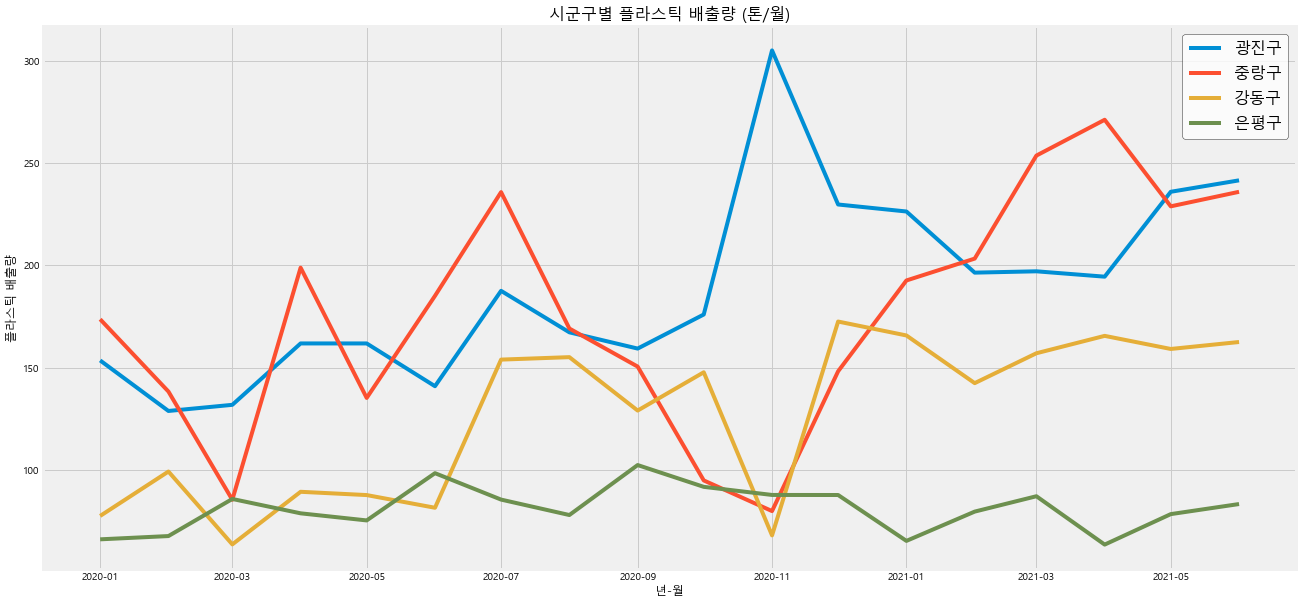

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(pd.unique(Recycle_waste["년-월"]), Recycle_waste[Recycle_waste["시군구명"] == "광진구"]["플라스틱"])
plt.plot(pd.unique(Recycle_waste["년-월"]), Recycle_waste[Recycle_waste["시군구명"] == "중랑구"]["플라스틱"])
plt.plot(pd.unique(Recycle_waste["년-월"]), Recycle_waste[Recycle_waste["시군구명"] == "강동구"]["플라스틱"])
plt.plot(pd.unique(Recycle_waste["년-월"]), Recycle_waste[Recycle_waste["시군구명"] == "은평구"]["플라스틱"])

plt.xlabel("년-월")
plt.ylabel("플라스틱 배출량")
plt.title("시군구별 플라스틱 배출량 (톤/월)", fontsize = 16)
legend = plt.legend(labels = ["광진구", "중랑구", "강동구", "은평구"], fontsize = 16)
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')

<AxesSubplot:title={'center':'서울 시 플라스틱 배출량 (광진구, 중랑구, 강동구, 은평구)'}, xlabel='년-월', ylabel='플라스틱 배출량'>

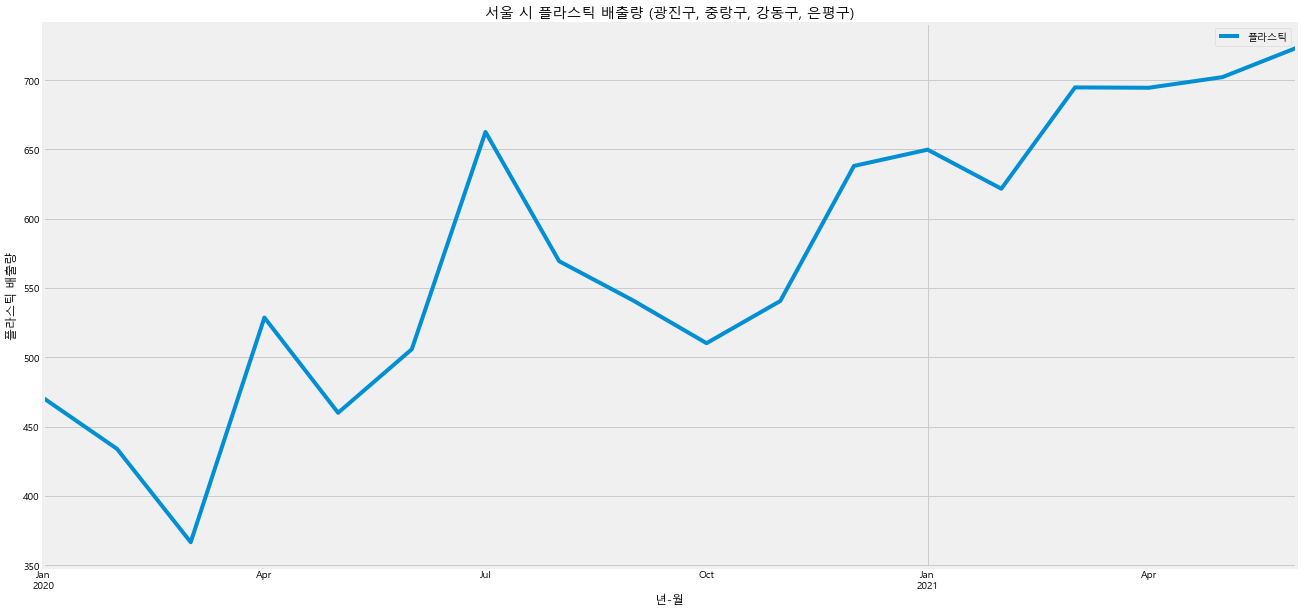

In [ ]:
Recycle_waste_sum = Recycle_waste.groupby("년-월").sum()

Recycle_waste_sum.plot(y = ["플라스틱"], figsize= (20, 10), title = "서울 시 플라스틱 배출량 (광진구, 중랑구, 강동구, 은평구)", ylabel = "플라스틱 배출량")

> 서울시의 2020년 플라스틱 발생량을 보면 코로나가 발생한 시점 이후 배달문화가 활성화되면서  꾸준하게 플라스틱의 발생량이 증가하는 것으로 보입니다.

Text(0.5, 0, '날짜')

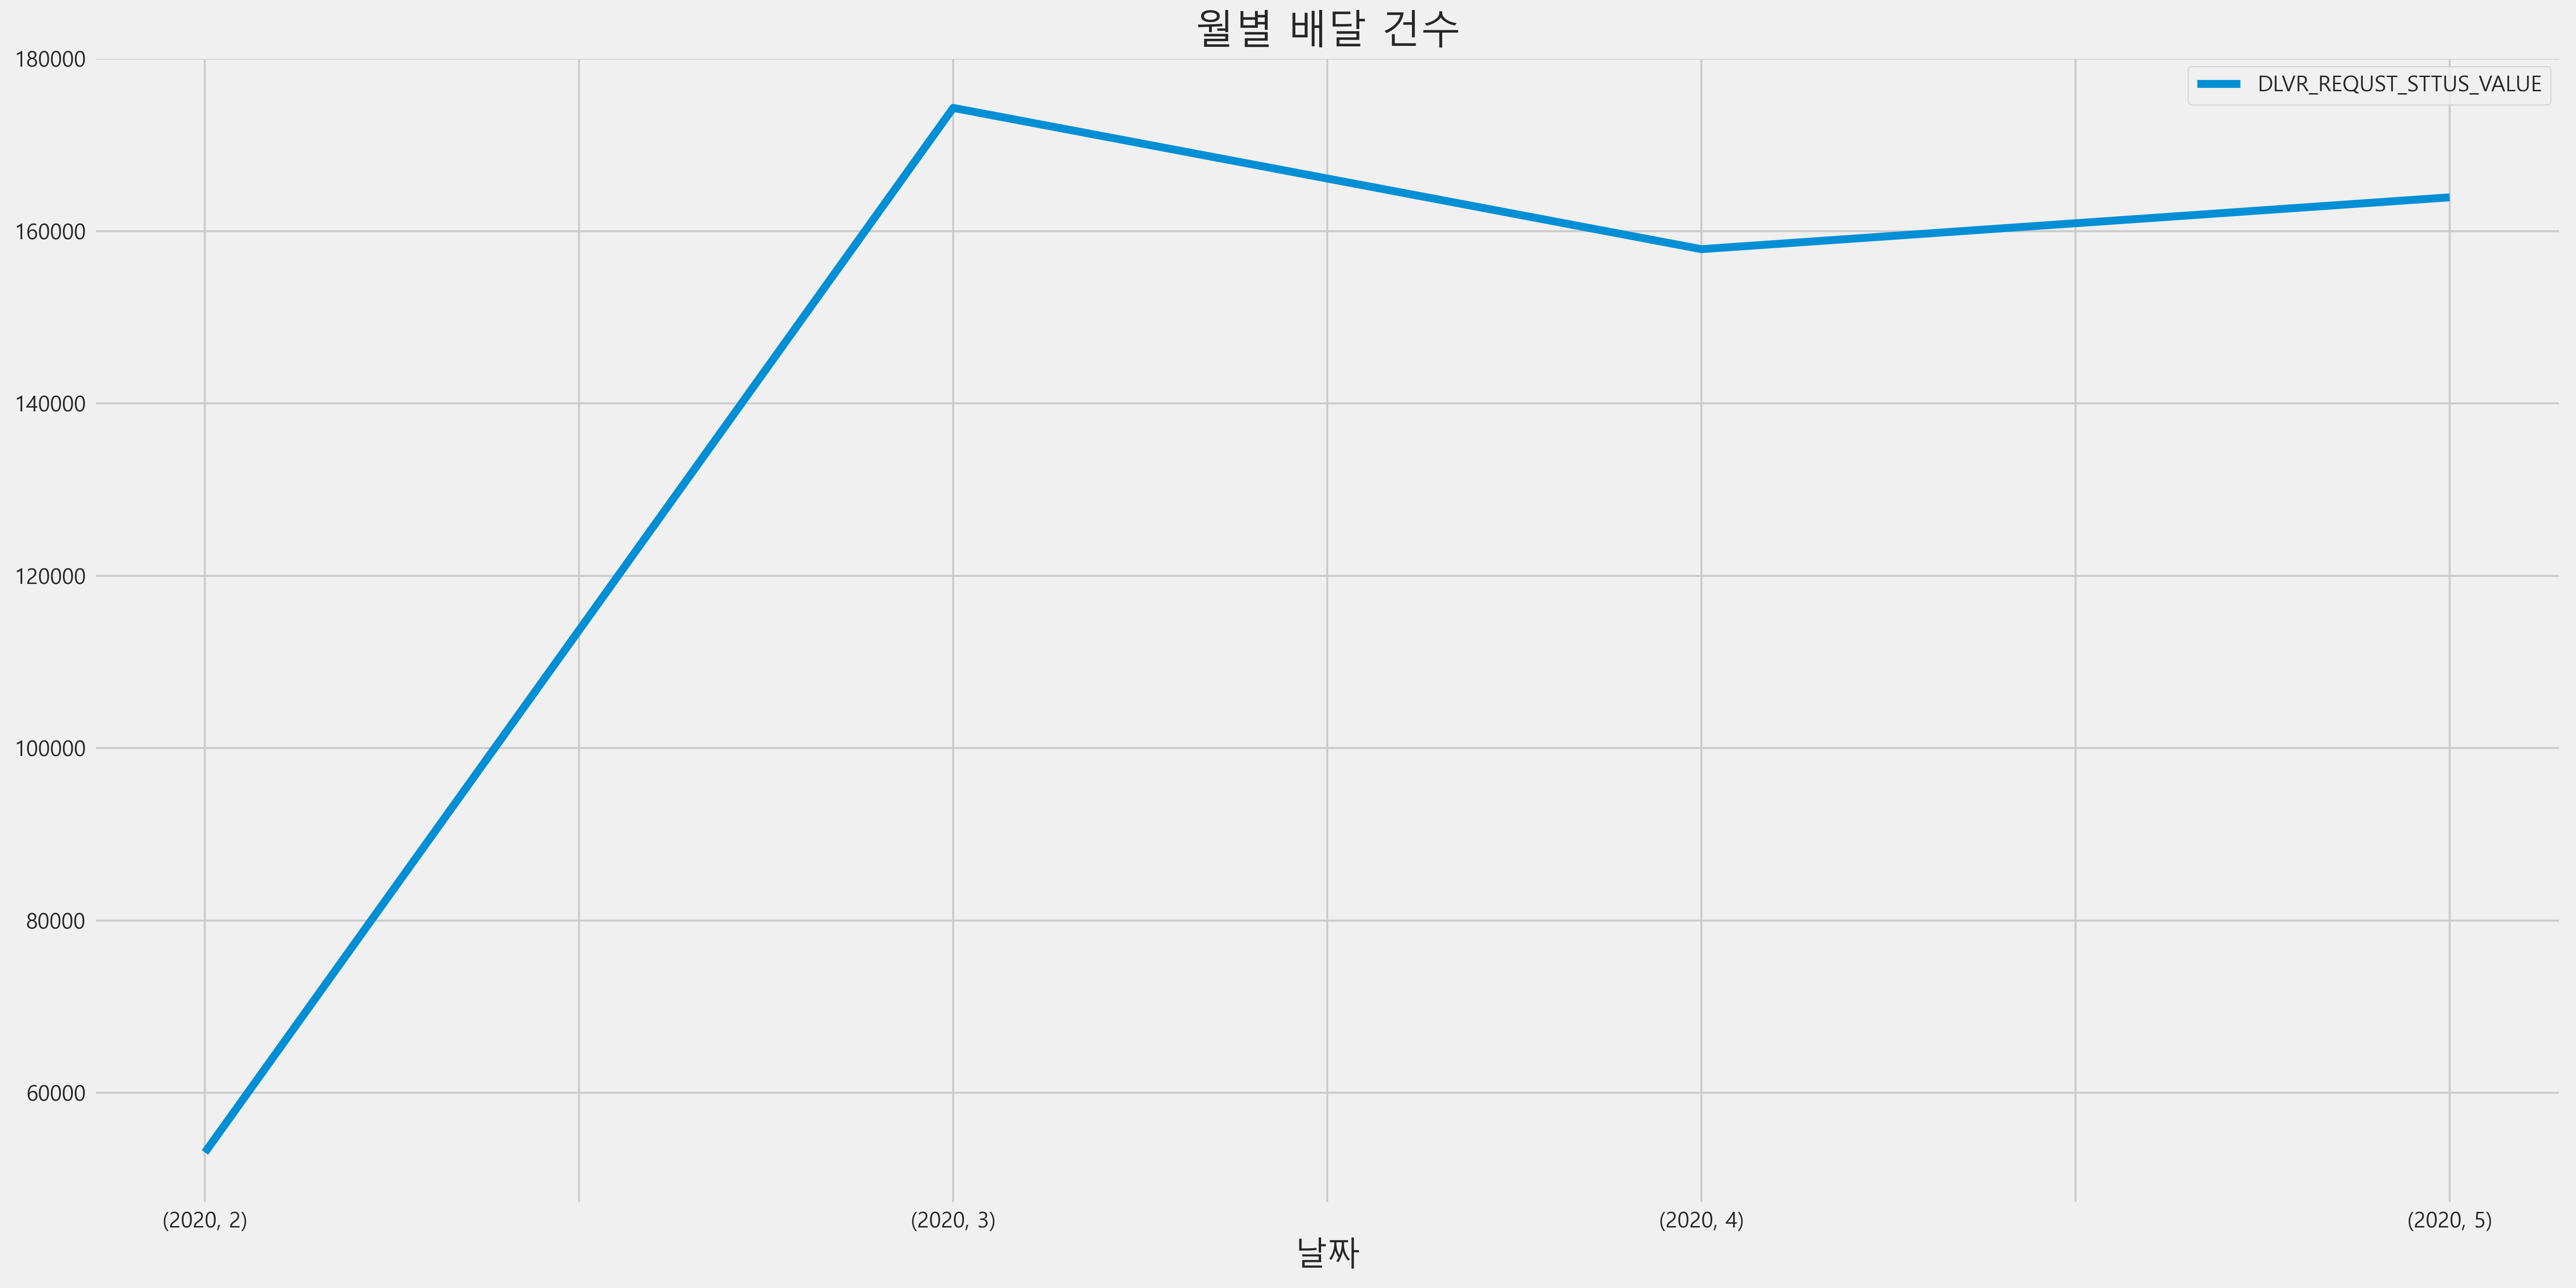

In [13]:
# 분석 시작일과 종료일 사이의 배달 건수 select
dlvr_call_range = dlvr_call[dlvr_call["PROCESS_DT"] >= first_epidemic]
dlvr_call_range = dlvr_call_range[dlvr_call_range["PROCESS_DT"] <= end_date]

# PROCESS_DT를 index로 지정
dlvr_call_range['DATE']=pd.to_datetime(dlvr_call['PROCESS_DT'],format="%Y-%m")
dlvr_call_range.set_index('DATE',inplace=True)

# 배달 완료된 주문만 사용
is_completed = dlvr_call_range["DLVR_REQUST_STTUS_VALUE"] == 1
dlvr_completed = dlvr_call_range[is_completed]

# 배달 완료된 주문을 년, 월을 기준으로 묶고, 각 년, 월에 발생한 배달 건수를 count
dlvr_groupby = dlvr_completed.groupby(by=[dlvr_completed.index.year, dlvr_completed.index.month])[["DLVR_REQUST_STTUS_VALUE"]].count()

# 월별 주문 건수
dlvr_groupby.plot(use_index = True, y = ["DLVR_REQUST_STTUS_VALUE"], figsize = (20, 10), title = "월별 배달 건수")
plt.xlabel('날짜')

>플라스틱 발생량과 배달건수의 데이터를 비교해보았습니다.

>배달건수가 높아질수록 플라스틱 발생량이 증가하는 것을 볼 수 있었습니다. 코로나가 계속해서 잠식되지 않으면서 배달건수가 많아지고 배달건수가 많아짐으로써 일회용품들의 사용량이 현저하게 늘어났기 때문에 플라스틱 발생량 또한 계속해서 많아지고 있습니다.  

<br>


# 4. 제안 및 기대효과

### 4-1. 필요성

>상기 분석 내용과 같이 코로나가 계속해서 진행됨으로써 배달량 또한 같이 증가하며 플라스틱 폐기물 또한 계속해서 증가하고 있습니다. 

>쓰레기 문제는 처리의 문제가 아닙니다. 발생부터 줄여야 쓰레기 문제를 해결할 수 있습니다. 한번 쓰고 버리는 것이 아니라 여러번 사용할 수 있는 조건을 마련하는 것을 최우선해야 한다고 생각합니다. 기업들은 생산/유통/판매 등 제품이 만들어지고 유통된 이후 폐기처리 될 때까지 전체 과정을 친환경적으로 고려해서 제품을 만들어야 한다고 생각합니다. 대량 생산하고, 대량 소비하는 시스템을 유지하는 삶의 방식이 달라지지 않는다면, 한번 쓰고 버리는 것이 익숙한 일상이 계속된다면, 쓰레기 속에서 삶을 사는 경험을 할지 모른다고 생각합니다. 

>데이터를 통한 플라스틱 증가량을 기반으로 뚜렷하게 보이는 것이 플라스틱 문제입니다. 그렇기 때문에 저희는 플라스틱 문제를 해결하기 위해서 플라스틱을 줄이는 수밖에 없을 것이라고 생각합니다.

### 4-2. 제안


* 배달 플랫폼 일회용 용기 및 수저 주문 안하기 챌린지
  * 배달 플랫폼에서 일회용 수저를 제공하지 않는 것을 기본으로 설정
  * 고객이 일회용 수저를 원할 시 일회용 수저 받기 체크란 설정

* 다회용기 사용하기
  * 경기도 배달특급에서 현재 테스트 진행 중
  * 다회용기를 사용함으로써 플라스틱 발생량을 감소시키고 다회용기 세척에 관한 일자리 창출 가능

* 친환경 일회용품 사용하기
  * 생산 및 발명기간에서 투자비용이 클 수 있으나 플라스틱 사용량을 현저하게 줄일 수 있음

<br>


# 5. 참고자료

## 출처

관련 뉴스 기사 링크
* “족발 2인분에 15개 일회용품...재활용 가능한 건 없었다” : https://www.hankookilbo.com/News/Read/A2021021213340000980
* "배달음식 시켰는데… 일회용품 폭탄" : http://biz.newdaily.co.kr/site/data/html/2020/09/15/2020091500088.html
* “[MZ세대의 '눈'] 배달 용기 '쓰레기의 민족'으로 역사에 남지 않기를” : http://www.busan.com/view/busan/view.php?code=2021080613513504763
* 경기도 배달특급 다회용기 배달, '깨끗할까?'..세척 업체 가보니 : https://news.v.daum.net/v/20210724060021617